#### On teste différentes architectures de VAE. On prend des petites architectures  pour commencer, que l'on peut apprendre sur moins de données, et on augmentera la taille ensuite.

In [1]:
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader 
import os 
import numpy as np

In [3]:
test_wav = np.load("../TrainValTest/testSet.npy")


## A. Première comparaison : VAE1D avec VAE2D

In [29]:
from downloader import SpectroDataset
from downloader import SpectroDataset4D
import models.simpleAE as AE
import models.vanillaVAE as VAE
import models.modules.bottleneck as BN
import models.modules.CNNdecoder as CNNdec
import models.modules.CNNencoder as CNNenc
import importlib as implib

implib.reload(AE)

<module 'models.simpleAE' from '/home/hippo/Documents/voiceVAE/models/simpleAE.py'>

In [45]:
validation_path = test_wav
torch.manual_seed(123)
spectros1 = SpectroDataset(validation_path)
valid_loader1 = DataLoader(spectros1,batch_size=16,shuffle=False)
spectros2 = SpectroDataset4D(validation_path)
valid_loader2 = DataLoader(spectros2,batch_size=16,shuffle=False)
spectros3 = SpectroDataset4D(validation_path)
valid_loader3 = DataLoader(spectros3,batch_size=16,shuffle=False)

#### les modèles testés doivent avoir été entrainés auparavant pour récupération des poids

### Modèle 1 : AE1D

In [46]:
model1 = AE.AE1D(32)
state_dic = torch.load("modelsParam/AE1D/ep5AE1D.pth")
model1.load_state_dict(state_dic)

<All keys matched successfully>

### Modèle 2 : AE2D

In [47]:
model2= AE.AE2D(64)
state_dic = torch.load("modelsParam/AE2D/ep5AE2D.pth")
model2.load_state_dict(state_dic)

<All keys matched successfully>

### Modèle 3 : vanillaVAE

In [48]:
vencoder = CNNenc.vanillaEncoder(64)
vdecoder = CNNdec.vanillaDecoder(64)
vbottleneck = BN.VariationalBottleneck(64)
model3 = VAE.vanillaVAE(encoder=vencoder,reconstructor = vdecoder,bottleneck=vbottleneck, beta = 1)
state_dic = torch.load("modelsParam/vanilla/ep5vanillaVAE_cluster.pth")
model3.load_state_dict(state_dic)

<All keys matched successfully>

# verification comparabilité des modèles 

#### même nombre de paramètres

In [36]:
#nombre de paramètres du modèle
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [49]:
print(count_parameters(model1))
print(count_parameters(model2))
print(count_parameters(model3))

41845
979424
6175488


#### Entrainement similaire (même nb d'epochs, batch, lr, nb de données, etc...)

## 1. Visualisation des reconstructions et comparaisons 2 à 2 de modèles 

In [50]:
batch1 = next(iter(valid_loader1))
batch2 = next(iter(valid_loader2))
batch3 = next(iter(valid_loader3))

recon1 = model1(batch1)
recon2 = model2(batch2)
recon3 = model3(batch3)

In [52]:
print(recon1.shape)
print(recon2.shape)
print(recon3['logits'].shape)

torch.Size([16, 21, 401])
torch.Size([16, 1, 401, 21])
torch.Size([16, 1, 401, 21])


__________SPECTRO n° 1  :   _______________
Spectro original :


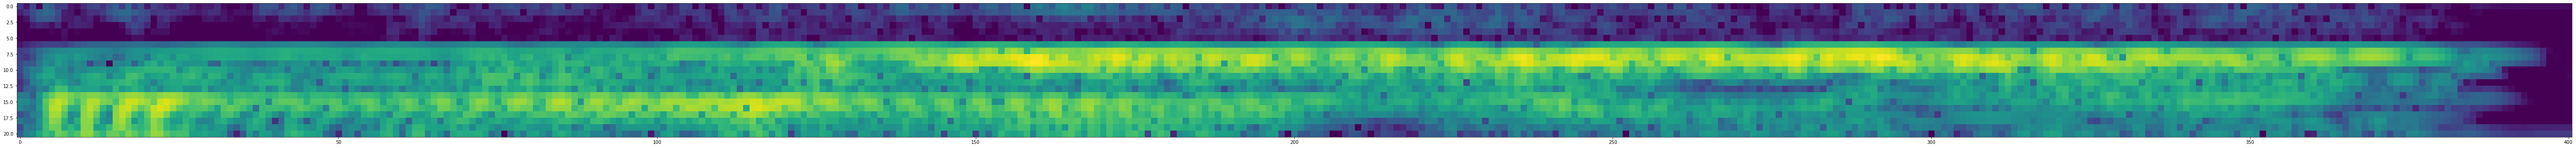

Reconstruction 1 :


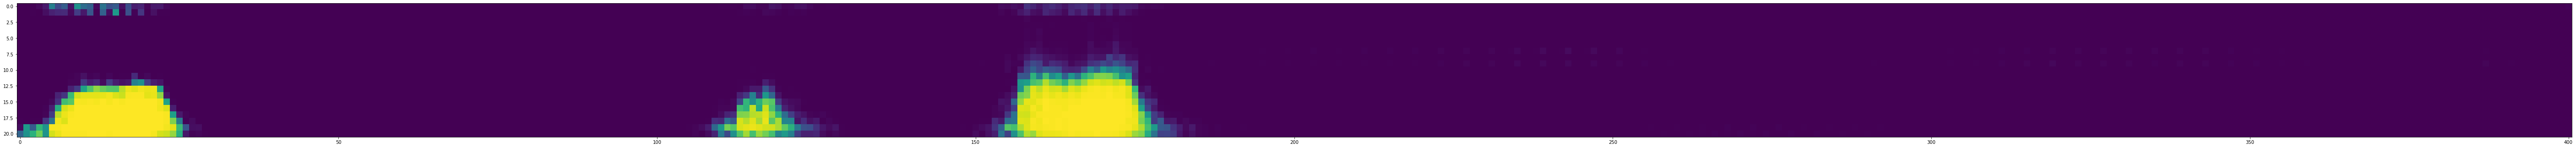

Reconstruction 2 :


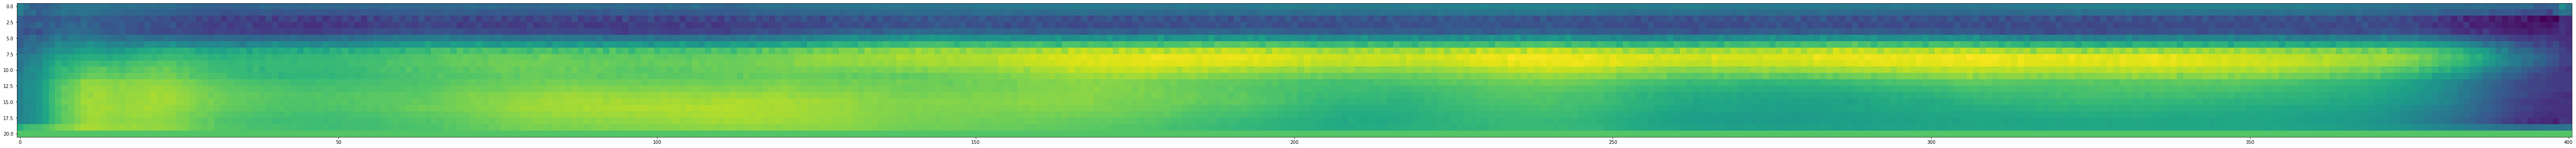

Reconstruction 3 :


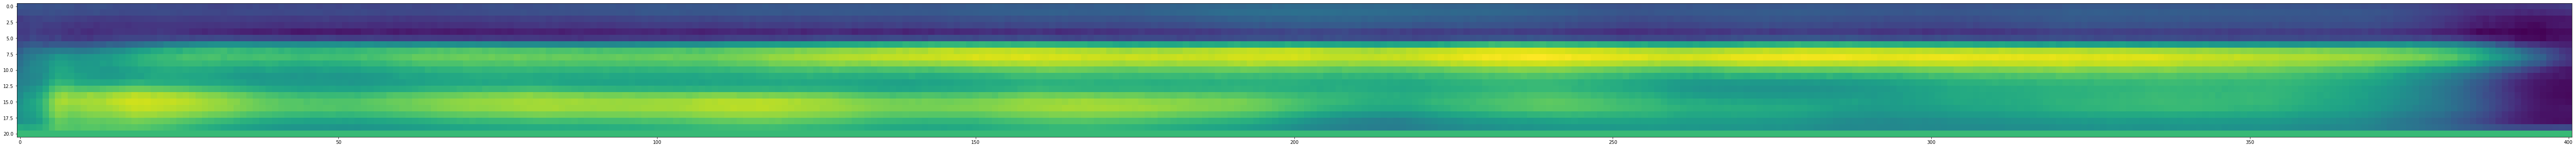

__________SPECTRO n° 2  :   _______________
Spectro original :


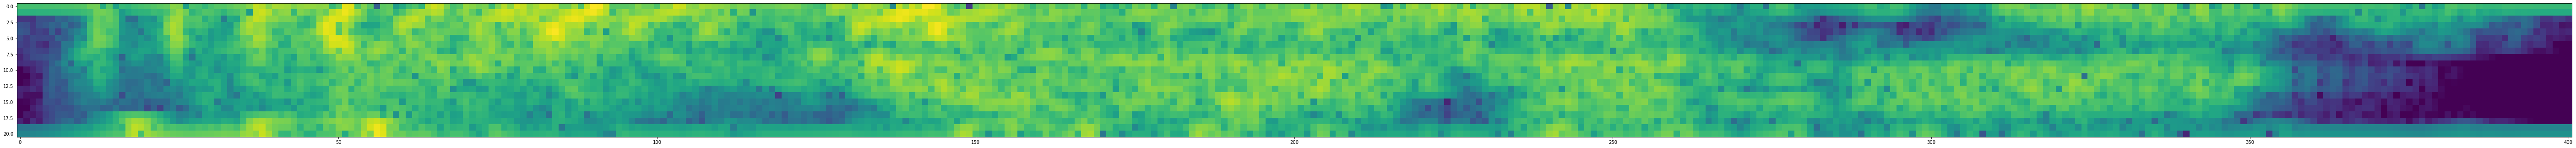

Reconstruction 1 :


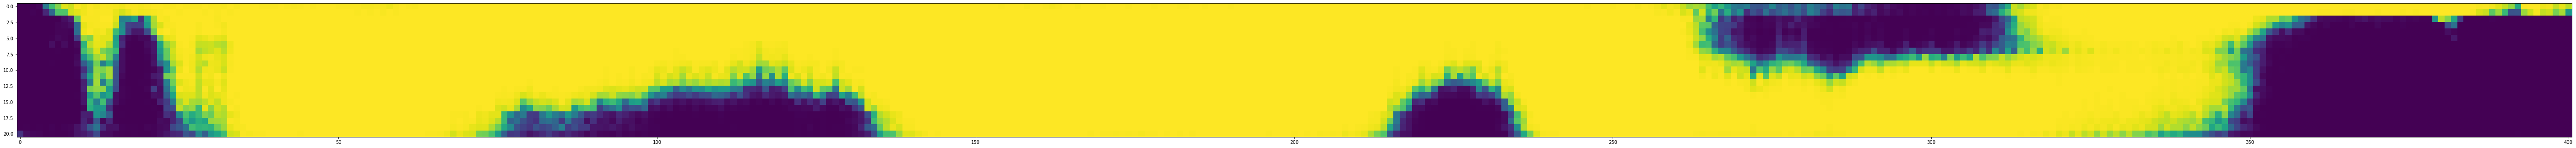

Reconstruction 2 :


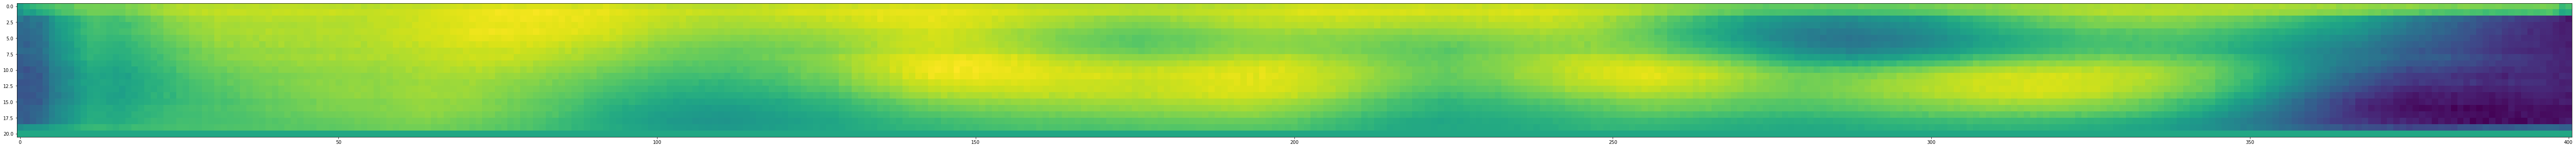

Reconstruction 3 :


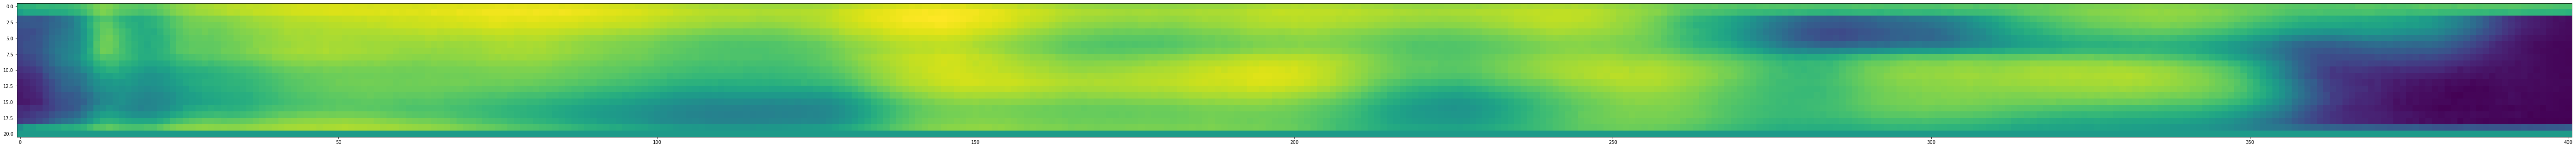

__________SPECTRO n° 3  :   _______________
Spectro original :


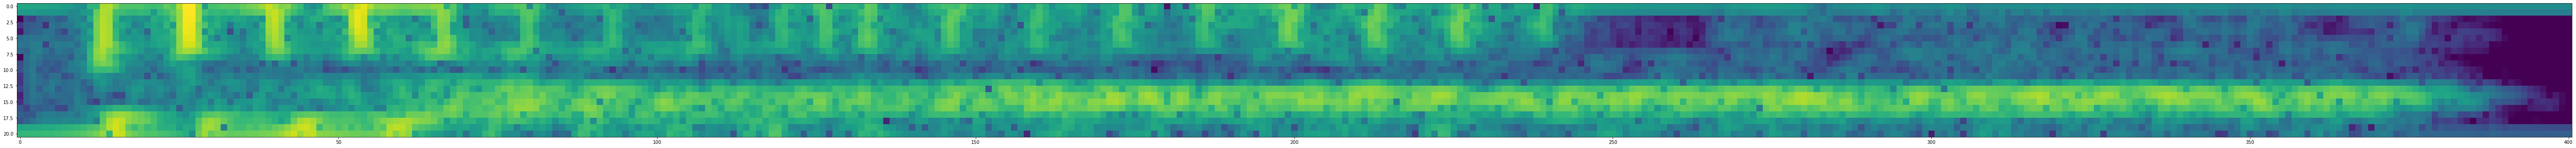

Reconstruction 1 :


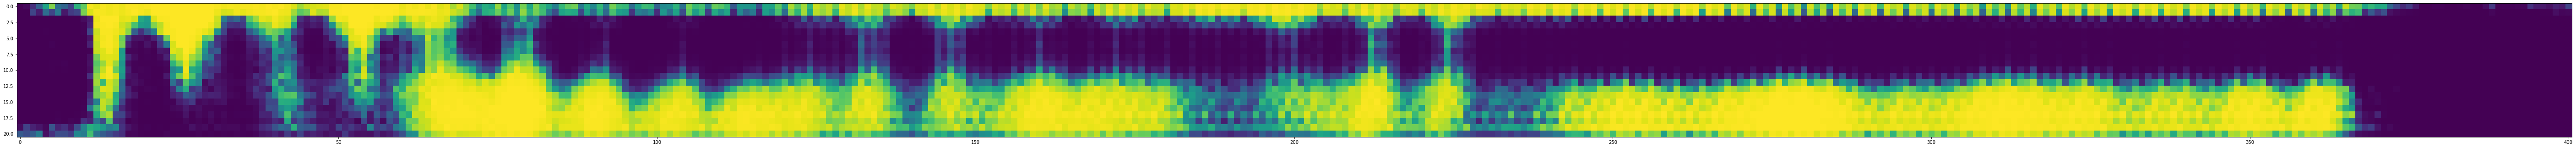

Reconstruction 2 :


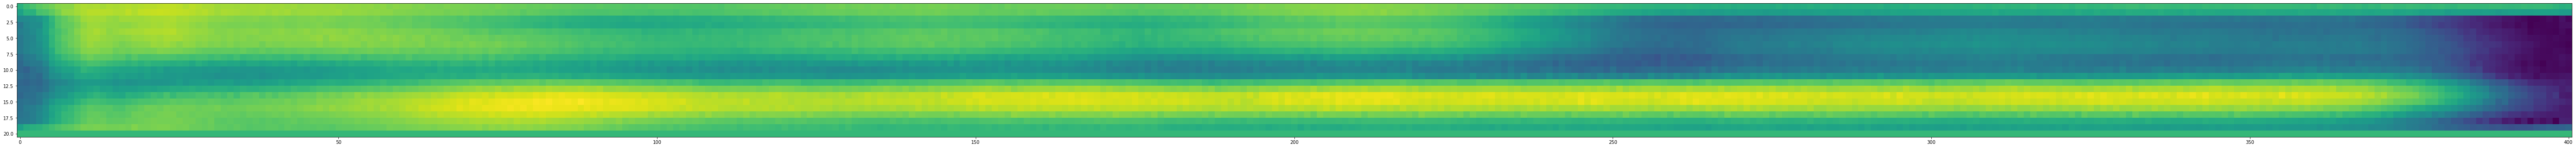

Reconstruction 3 :


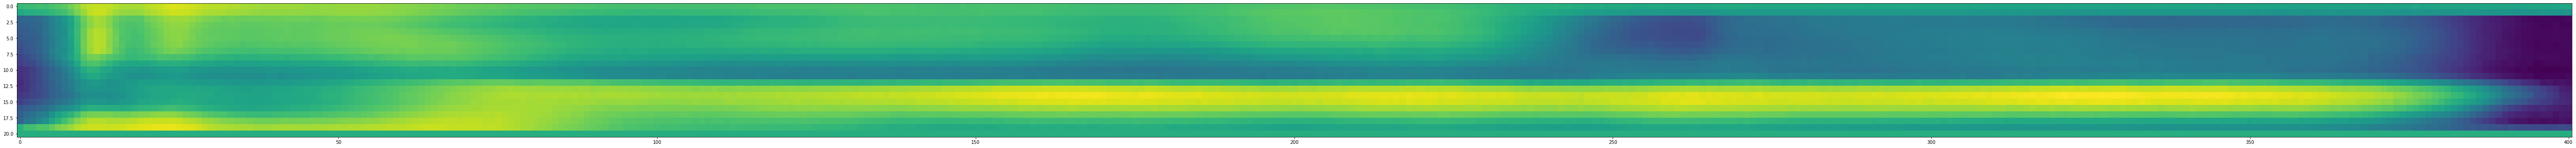

__________SPECTRO n° 4  :   _______________
Spectro original :


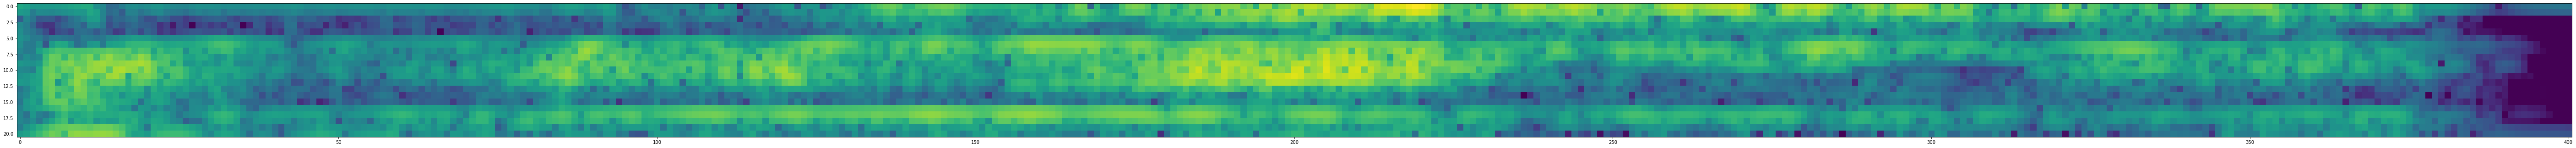

Reconstruction 1 :


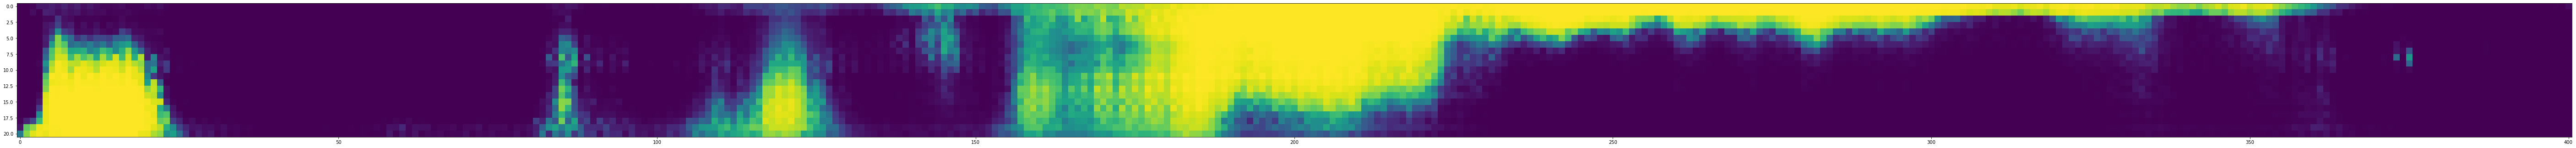

Reconstruction 2 :


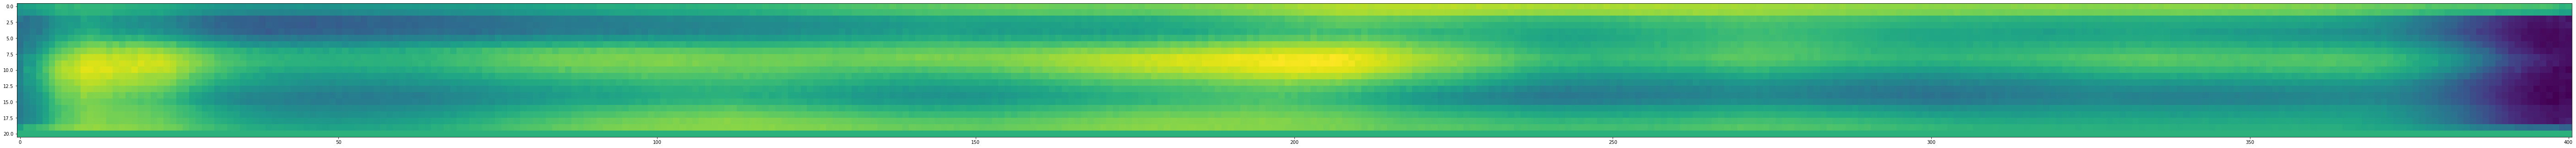

Reconstruction 3 :


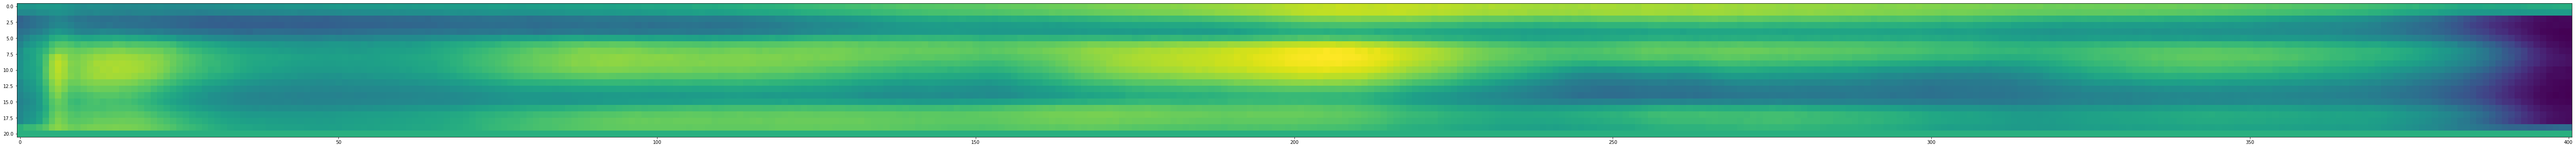

__________SPECTRO n° 5  :   _______________
Spectro original :


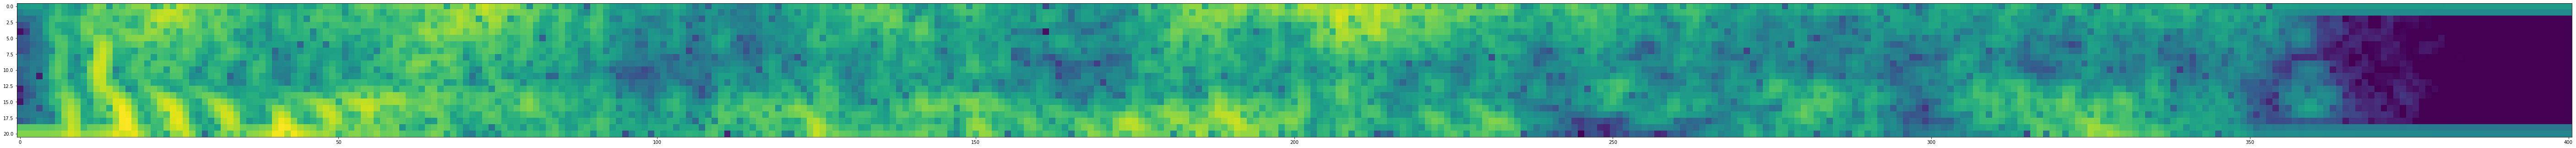

Reconstruction 1 :


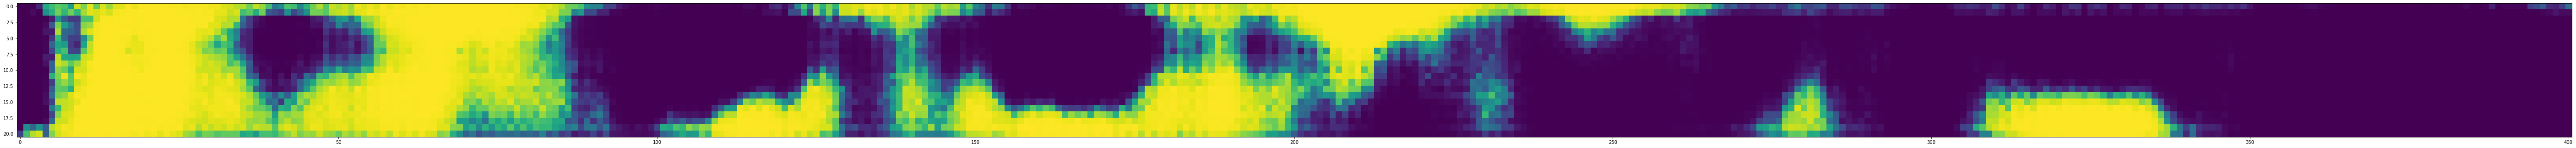

Reconstruction 2 :


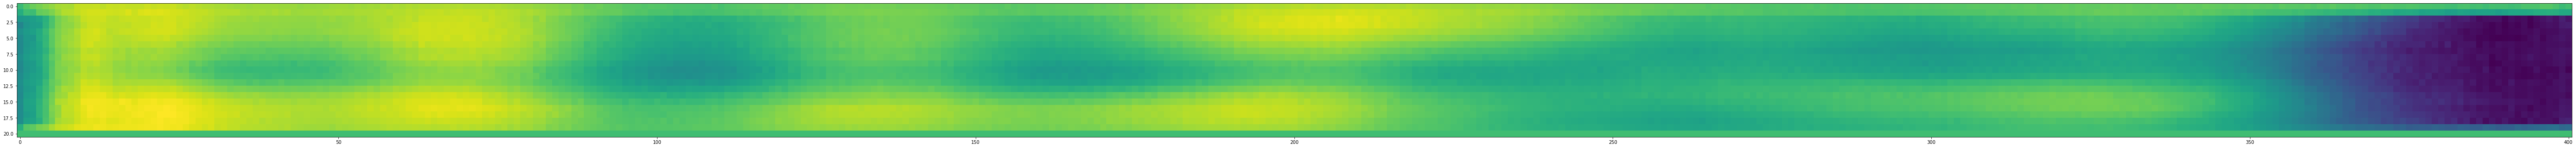

Reconstruction 3 :


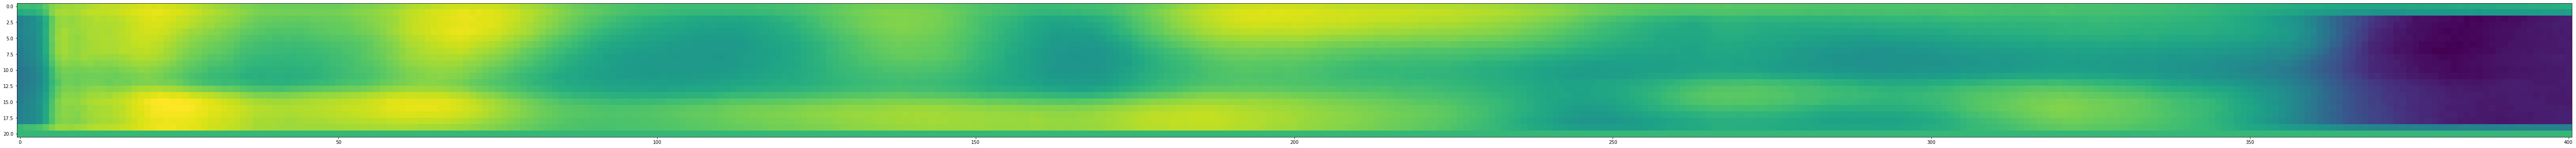

__________SPECTRO n° 6  :   _______________
Spectro original :


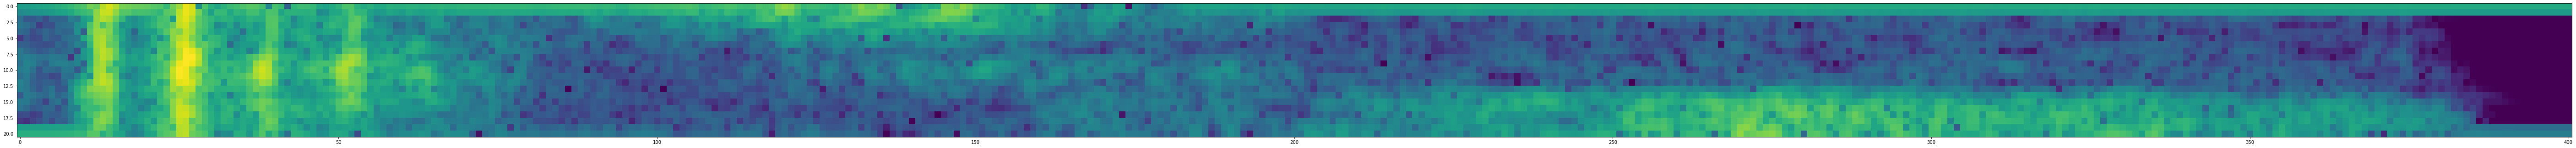

Reconstruction 1 :


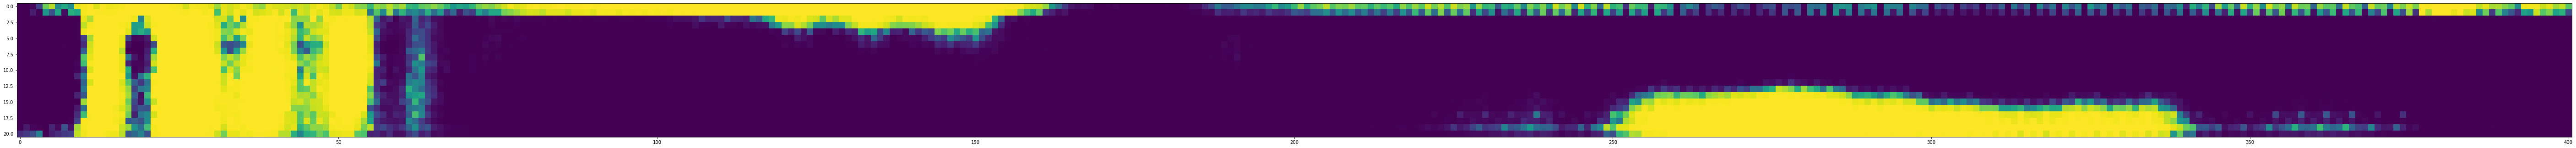

Reconstruction 2 :


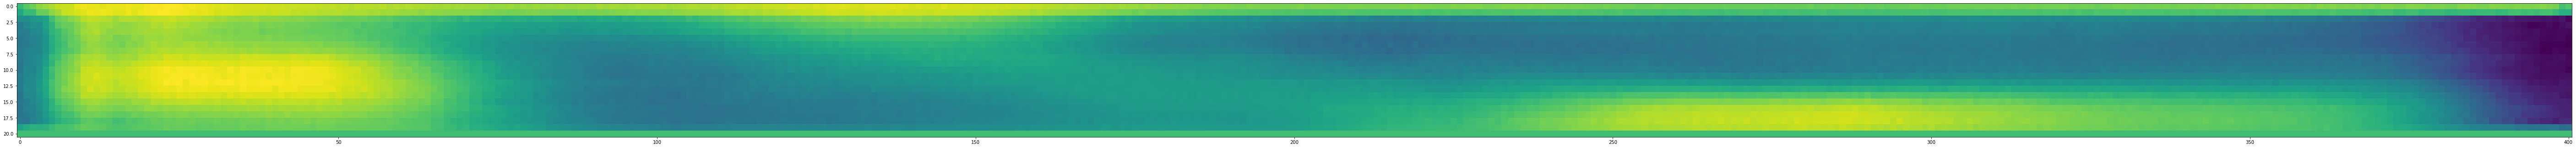

Reconstruction 3 :


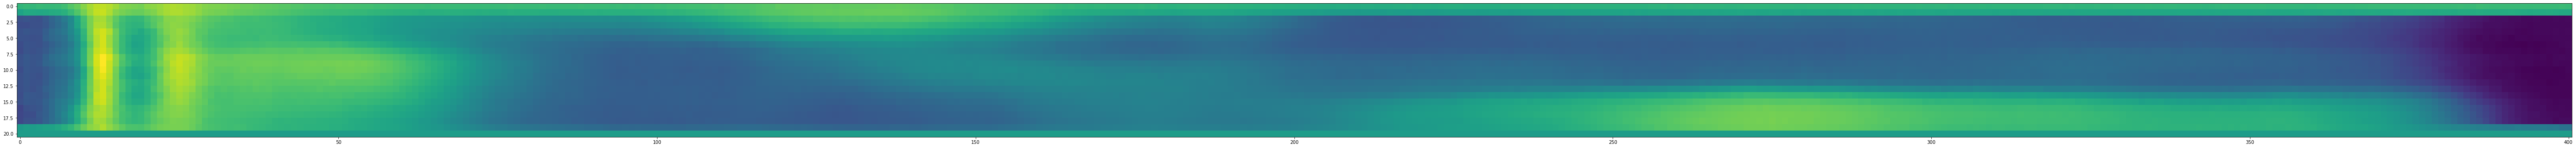

__________SPECTRO n° 7  :   _______________
Spectro original :


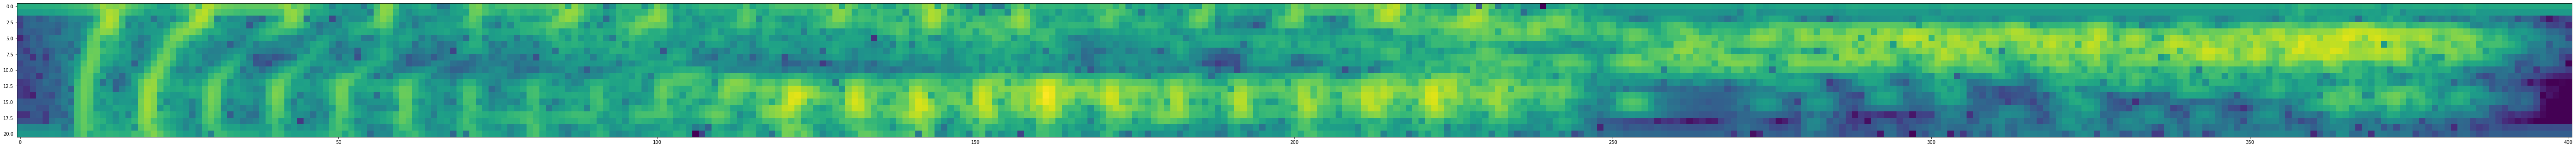

Reconstruction 1 :


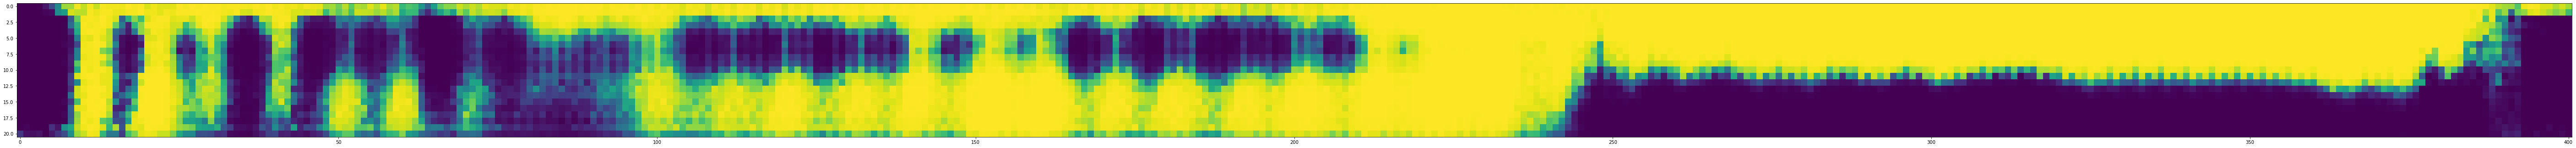

Reconstruction 2 :


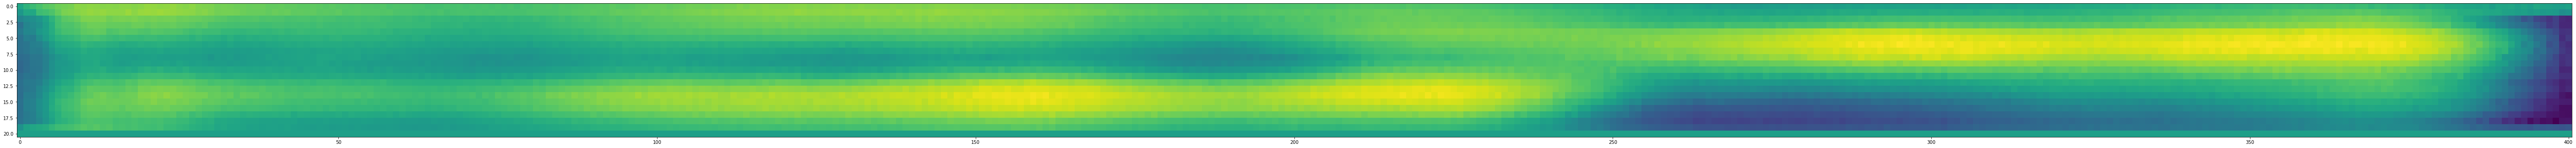

Reconstruction 3 :


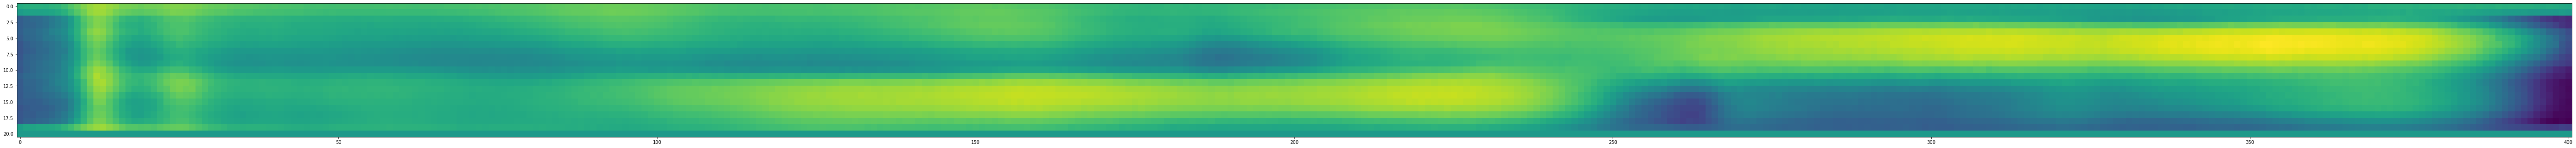

__________SPECTRO n° 8  :   _______________
Spectro original :


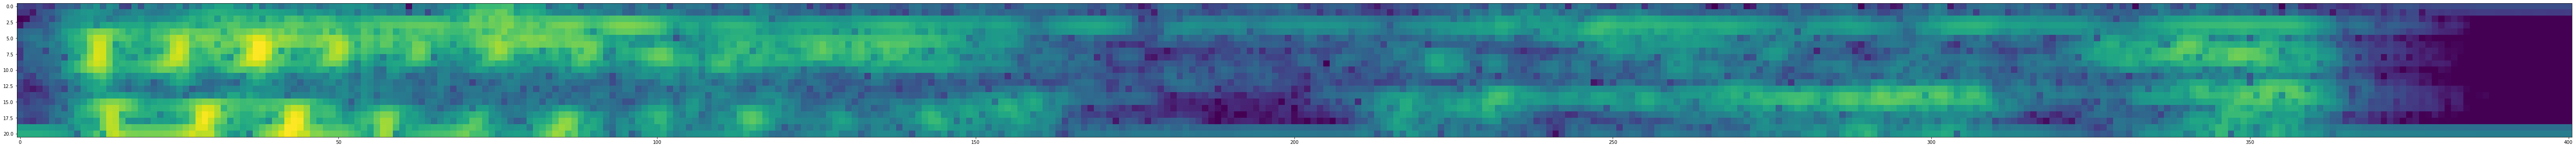

Reconstruction 1 :


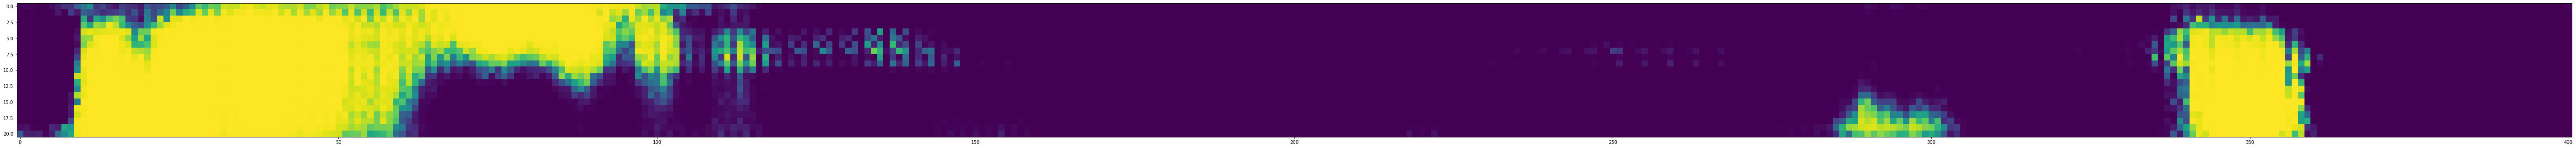

Reconstruction 2 :


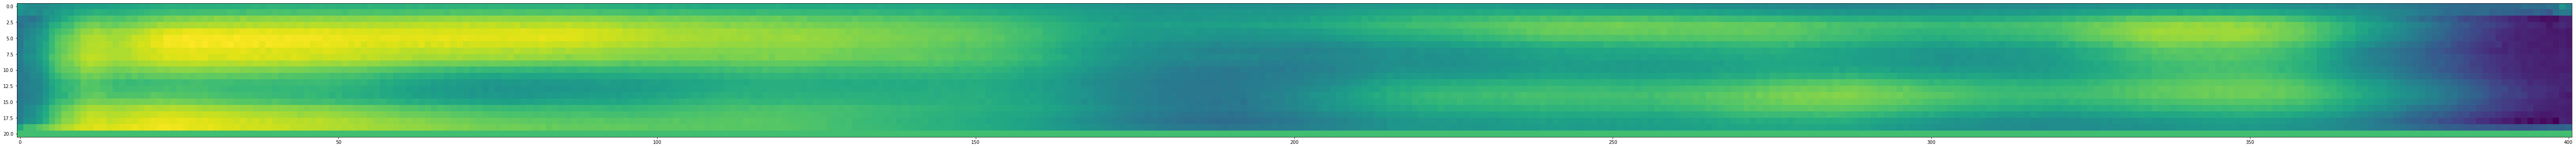

Reconstruction 3 :


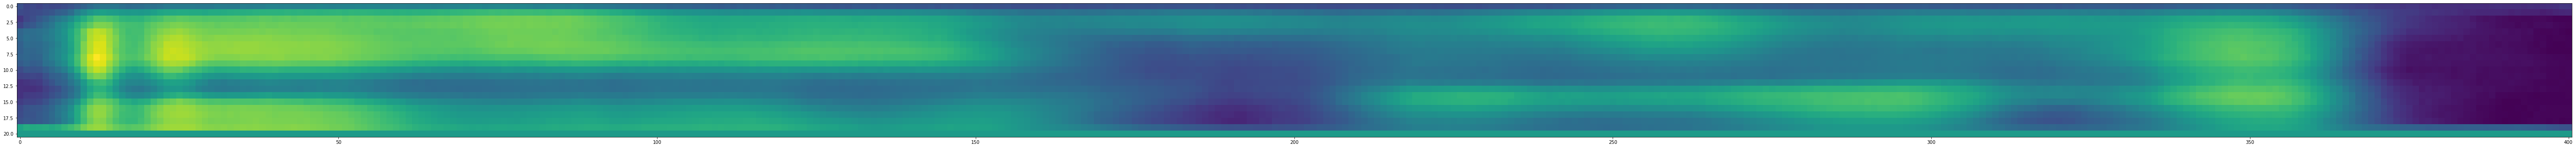

__________SPECTRO n° 9  :   _______________
Spectro original :


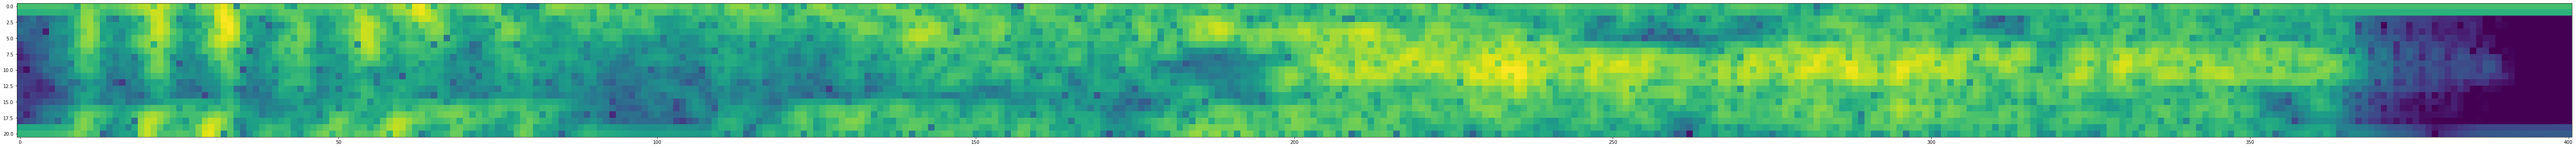

Reconstruction 1 :


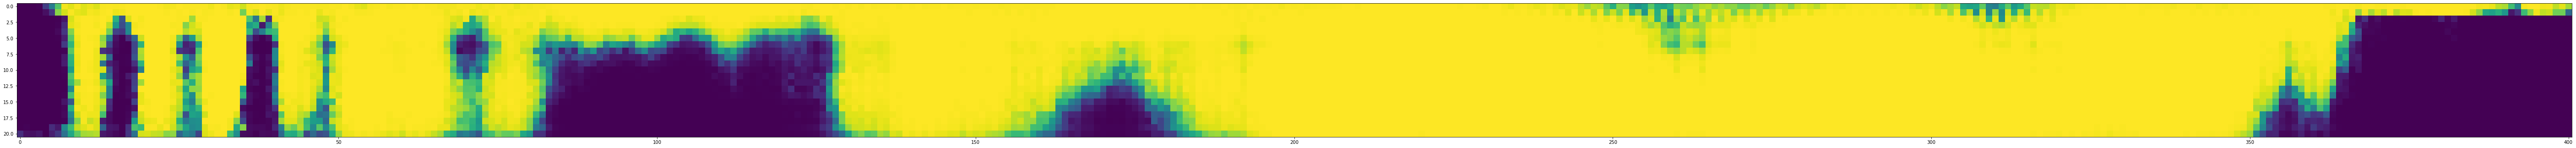

Reconstruction 2 :


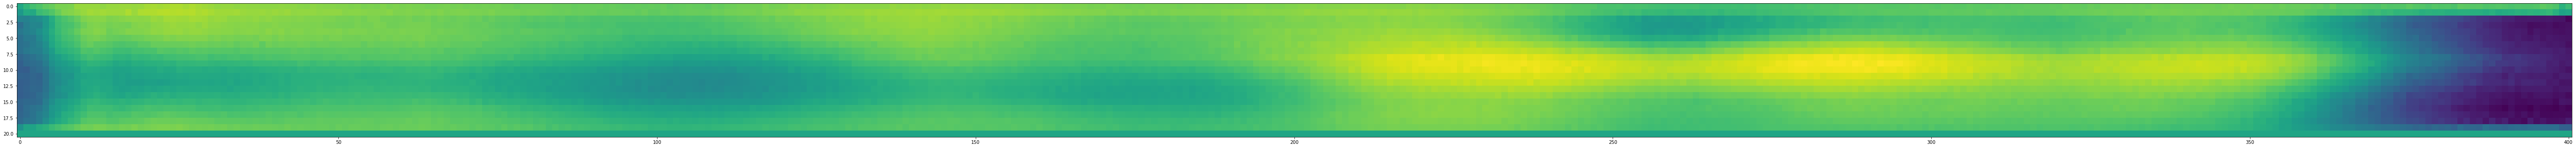

Reconstruction 3 :


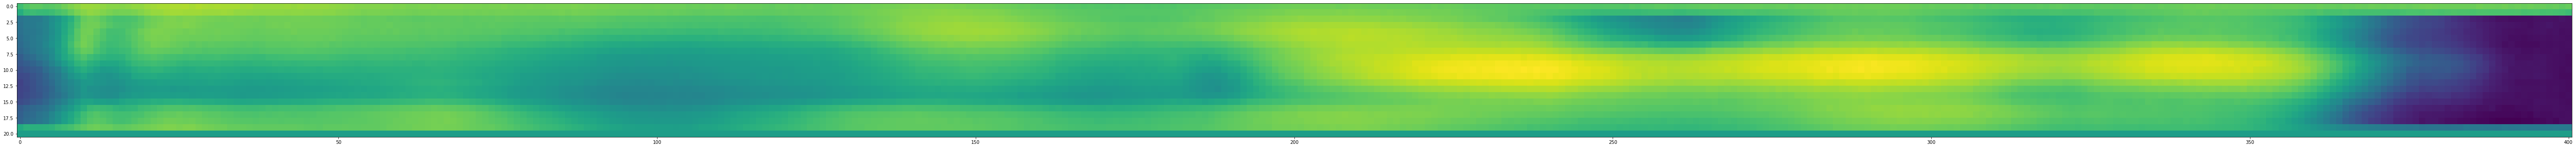

__________SPECTRO n° 10  :   _______________
Spectro original :


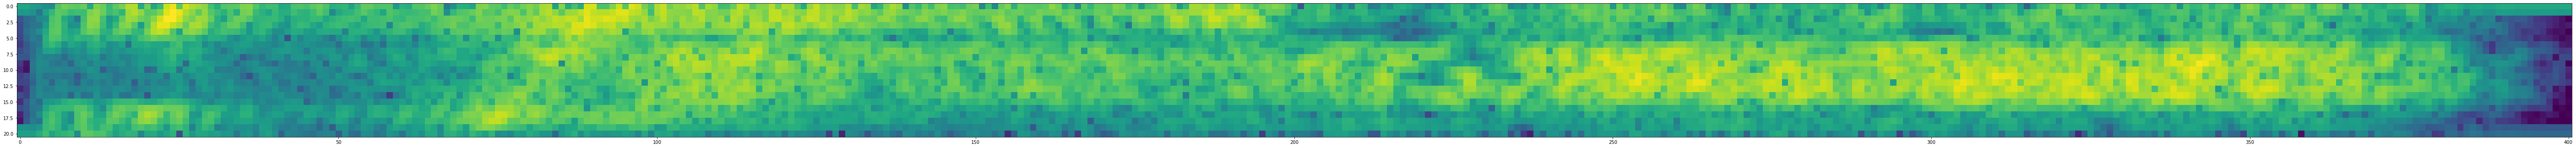

Reconstruction 1 :


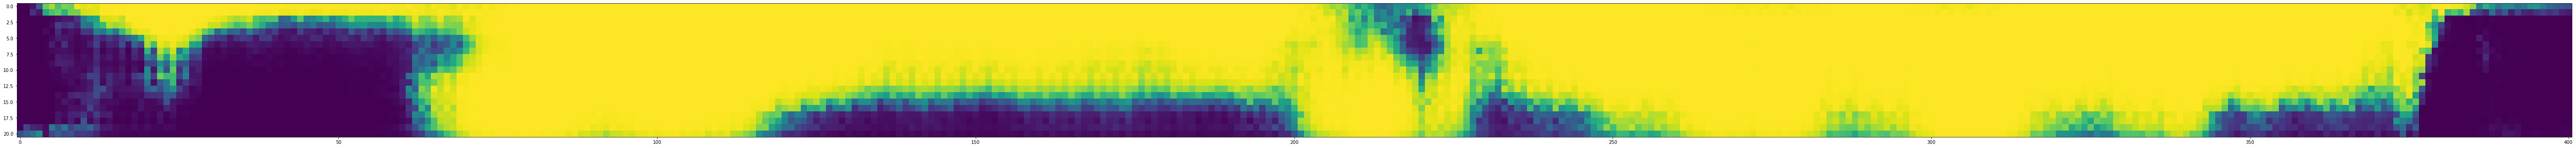

Reconstruction 2 :


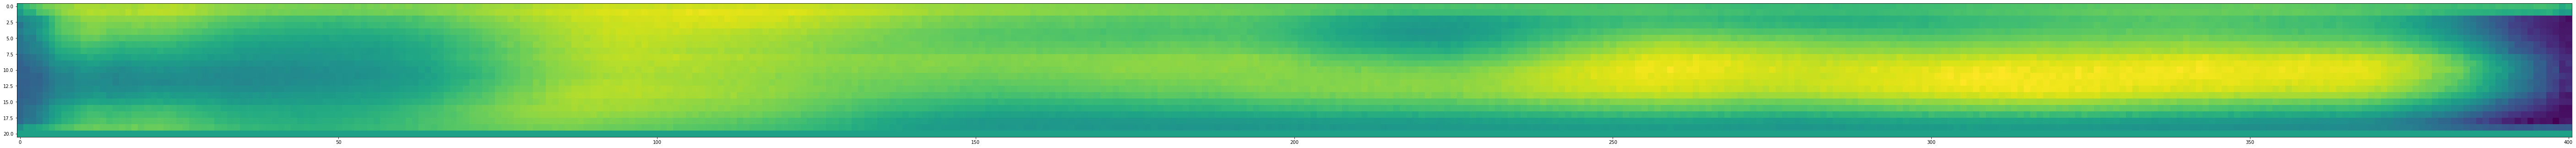

Reconstruction 3 :


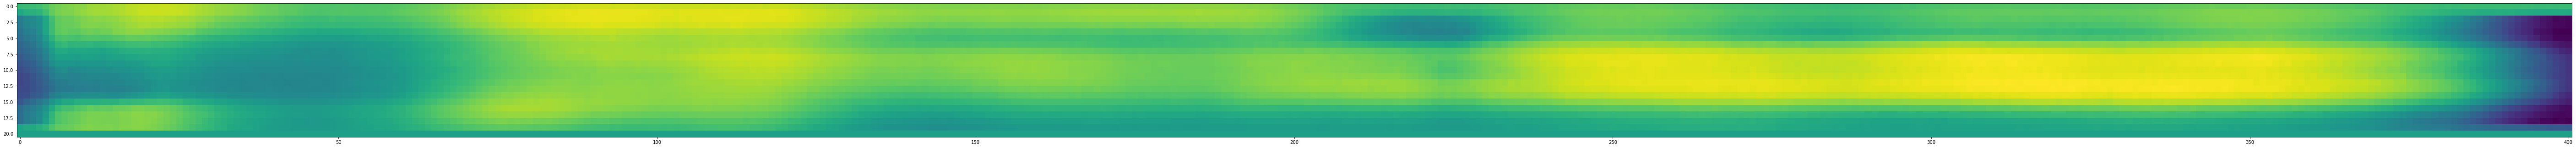

In [55]:
import matplotlib.pyplot as plt

#affichage des reocnstruction et des spectros originaux 
plt.rcParams['figure.figsize'] = [100, 50]
for i in range(10):
    print('__________SPECTRO n°',i+1,' :   _______________')
    print('Spectro original :')
    plt.imshow(np.transpose(batch2[i][0].detach().numpy()))
    plt.show()
    print('Reconstruction 1 :')
    plt.imshow(recon1[i].detach().numpy())
    plt.show()
    print('Reconstruction 2 :')
    plt.imshow(np.transpose(recon2[i][0].detach().numpy()))
    plt.show()
    print('Reconstruction 3 :')
    plt.imshow(np.transpose(recon3['logits'][i][0].detach().numpy()))
    plt.show()


Pourquoi le 1D et le 2D se comporte t-il comme ça ? le 1D est beaucoup moins blurry temporellement car il se concentre uniquement sur la reconstruction temporelle, sans se soucier de reconcilier les différentes fréquences ensembles.
Et comme le son est avant tout temporelle, c'est pas si inintéressant non ?

## 2. Etude des espaces latents construits

# B. 2eme comparaison vanillaVAE et AE